<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_13/S13_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First Connect Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


Install packages

In [2]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git -C ERA_V1 pull
#!cd ../
!git clone "https://github.com/jyanivaddi/dl_hub.git"
!git -C dl_hub pull
!git pull
#!cd ../

!pip install --quiet "torchinfo" "seaborn" "pytorch-lightning" "torchmetrics" "lightning-bolts"
!pip install --quiet "prettytable"
!pip install --quiet "torchsummary"
!pip install --quiet "torch_lr_finder"
!pip install --quiet "grad-cam"
!pip install --quiet "gradio"

fatal: destination path 'ERA_V1' already exists and is not an empty directory.
Already up to date.
fatal: destination path 'dl_hub' already exists and is not an empty directory.
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), 732 bytes | 732.00 KiB/s, done.
From https://github.com/jyanivaddi/dl_hub
   8b10c2f..bbcd00a  main       -> origin/main
Updating 8b10c2f..bbcd00a
Fast-forward
 YOLO_V3/config.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)
fatal: not a git repository (or any of the parent directories): .git


In [3]:
import sys
sys.path.append("ERA_V1/session_13")
sys.path.append("dl_hub")

In [4]:
!git -C dl_hub pull


Already up to date.


In [5]:
import dl_hub.YOLO_V3.config as config
import torch
import torch.optim as optim
import os
from dl_hub.YOLO_V3.model import YOLOv3
from tqdm import tqdm
from dl_hub.YOLO_V3.yolo_v3_utils.utils import (
    mean_average_precision,
    cells_to_bboxes,
    get_evaluation_bboxes,
    save_checkpoint,
    load_checkpoint,
    check_class_accuracy,
    get_loaders,
    plot_couple_examples
)
from dl_hub.YOLO_V3.yolo_v3_utils.loss import YoloLoss
from dl_hub.YOLO_V3.PL_model import LitYOLOv3
from dl_hub.YOLO_V3.yolo_v3_utils.PL_data_module import YOLODataModule
from dl_hub.PL_main import train_and_eval_pl_model
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/usr/local/lib/python3.10/dist-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The feature FeatureMapContrastiveTask is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  contrastive_task: Union[FeatureMapContrastiveTask] = FeatureMapCon

In [6]:
print(config.DATASET)


/content/gdrive/MyDrive/Datasets/PASCAL_VOC_SMALL


**Define Data Module**

In [7]:
# Define data module
#csv_files = [os.path.join(config.DATASET, "100examples.csv"),os.path.join(config.DATASET,"8examples.csv")]
csv_files = [os.path.join(config.DATASET, "train.csv"),os.path.join(config.DATASET,"test.csv")]
train_transforms=config.train_transforms
test_transforms=config.test_transforms
val_transforms = test_transforms
IMAGE_SIZE = config.IMAGE_SIZE
S=[IMAGE_SIZE // 32, IMAGE_SIZE // 16, IMAGE_SIZE // 8]
img_dir=config.IMG_DIR
label_dir=config.LABEL_DIR
anchors=config.ANCHORS
batch_size = 16
yolo_dm = YOLODataModule(
    csv_files,
    img_dir,
    label_dir,
    anchors,
    batch_size,
    image_size=IMAGE_SIZE,
    S=S,
    C=20,
    train_transforms = train_transforms,
    val_transforms = val_transforms,
    test_transforms = test_transforms,
    val_split=0.1,
    num_workers = config.NUM_WORKERS,
    use_mosaic_on_train=True,
    mosaic_probability=0.75,
    pin_memory = False)
yolo_dm.prepare_data()
yolo_dm.setup()

**Identify best LR**

  0%|          | 0/200 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 6.75E-02


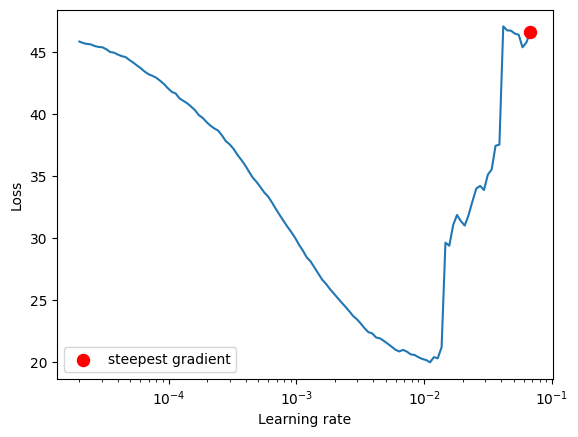

In [ ]:
from torch_lr_finder import LRFinder
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5

# Define Model
dummy_yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(dummy_yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
train_data_loader = yolo_dm.train_dataloader()


def criterion(out, y):
    y0, y1, y2 = (
            y[0].to(config.DEVICE),
            y[1].to(config.DEVICE),
            y[2].to(config.DEVICE),
        )
    loss = (
                loss_fn(out[0], y0, scaled_anchors[0])
                + loss_fn(out[1], y1, scaled_anchors[1])
                + loss_fn(out[2], y2, scaled_anchors[2])
            )
    return loss
lr_finder = LRFinder(dummy_yolo_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_data_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
max_lr = 8E-4

**Train model**

In [ ]:
from dl_hub.YOLO_V3.PL_main import train_yolov3_model
from torch.optim.lr_scheduler import OneCycleLR

# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
loss_fn = YoloLoss()
conf_threshold = config.CONF_THRESHOLD
EPOCHS = config.NUM_EPOCHS * 2 // 5
train_data_loader = yolo_dm.train_dataloader()

# Define Model
yolo_model = LitYOLOv3(loss_fn, scaled_anchors,conf_threshold, optimizer=None, scheduler_dict=None, num_classes=20, epochs=EPOCHS)
optimizer = optim.Adam(yolo_model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_data_loader),
    epochs=EPOCHS,
    pct_start=5/EPOCHS,
    div_factor=100,
    three_phase=False,
    final_div_factor=100,
    anneal_strategy='linear'
)
yolo_model.set_optimizer(optimizer)
yolo_model.set_scheduler_dict(scheduler,freq='step')

trainer = train_yolov3_model(yolo_model, yolo_dm, epochs=EPOCHS)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type     | Params
--------------------------------------------
0 | model          | YOLOv3   | 61.6 M
1 | loss_criterion | YoloLoss | 0     
--------------------------------------------
61.6 M    Trainable params
0         Non-trainable params
61.6 M    Total params
123.253   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

epoch: 0  val_Class_Accuracy: 25.490198135375977
epoch: 0  val_No_Obj_Accuracy: 92.9794921875
epoch: 0  val_Obj_Accuracy: 15.686275482177734
epoch: 0  val_Class_Accuracy: 54.074073791503906
epoch: 0  val_No_Obj_Accuracy: 89.71428680419922
epoch: 0  val_Obj_Accuracy: 28.88888931274414
epoch: 0  val_Class_Accuracy: 16.666667938232422
epoch: 0  val_No_Obj_Accuracy: 92.52114868164062
epoch: 0  val_Obj_Accuracy: 19.44444465637207
epoch: 0  val_Class_Accuracy: 55.9748420715332
epoch: 0  val_No_Obj_Accuracy: 90.7790756225586
epoch: 0  val_Obj_Accuracy: 13.207547187805176
epoch: 0  val_Class_Accuracy: 32.291664123535156
epoch: 0  val_No_Obj_Accuracy: 91.59721374511719
epoch: 0  val_Obj_Accuracy: 20.833332061767578
epoch: 0  val_Class_Accuracy: 31.94444465637207
epoch: 0  val_No_Obj_Accuracy: 91.22269439697266
epoch: 0  val_Obj_Accuracy: 18.05555534362793
epoch: 0  val_Class_Accuracy: 27.77777862548828
epoch: 0  val_No_Obj_Accuracy: 92.5196762084961
epoch: 0  val_Obj_Accuracy: 17.77777862548828

Validation: 0it [00:00, ?it/s]

epoch: 1  val_Class_Accuracy: 36.27450942993164
epoch: 1  val_No_Obj_Accuracy: 99.63699340820312
epoch: 1  val_Obj_Accuracy: 1.9607844352722168
epoch: 1  val_Class_Accuracy: 41.48147964477539
epoch: 1  val_No_Obj_Accuracy: 99.53115844726562
epoch: 1  val_Obj_Accuracy: 2.9629628658294678
epoch: 1  val_Class_Accuracy: 14.814814567565918
epoch: 1  val_No_Obj_Accuracy: 99.44607543945312
epoch: 1  val_Obj_Accuracy: 3.7037036418914795
epoch: 1  val_Class_Accuracy: 60.377357482910156
epoch: 1  val_No_Obj_Accuracy: 99.38421630859375
epoch: 1  val_Obj_Accuracy: 3.7735848426818848
epoch: 1  val_Class_Accuracy: 37.5
epoch: 1  val_No_Obj_Accuracy: 99.5442123413086
epoch: 1  val_Obj_Accuracy: 4.1666669845581055
epoch: 1  val_Class_Accuracy: 30.55555534362793
epoch: 1  val_No_Obj_Accuracy: 99.58069610595703
epoch: 1  val_Obj_Accuracy: 5.555555820465088
epoch: 1  val_Class_Accuracy: 31.111112594604492
epoch: 1  val_No_Obj_Accuracy: 99.85845184326172
epoch: 1  val_Obj_Accuracy: 3.3333334922790527
epoc

Validation: 0it [00:00, ?it/s]

epoch: 2  val_Class_Accuracy: 43.13725662231445
epoch: 2  val_No_Obj_Accuracy: 99.862548828125
epoch: 2  val_Obj_Accuracy: 3.9215688705444336
epoch: 2  val_Class_Accuracy: 24.44444465637207
epoch: 2  val_No_Obj_Accuracy: 99.81552124023438
epoch: 2  val_Obj_Accuracy: 2.222222328186035
epoch: 2  val_Class_Accuracy: 18.518518447875977
epoch: 2  val_No_Obj_Accuracy: 99.81672668457031
epoch: 2  val_Obj_Accuracy: 1.8518518209457397
epoch: 2  val_Class_Accuracy: 44.02515411376953
epoch: 2  val_No_Obj_Accuracy: 99.6592025756836
epoch: 2  val_Obj_Accuracy: 2.51572322845459
epoch: 2  val_Class_Accuracy: 33.333335876464844
epoch: 2  val_No_Obj_Accuracy: 99.78326416015625
epoch: 2  val_Obj_Accuracy: 1.0416667461395264
epoch: 2  val_Class_Accuracy: 33.333335876464844
epoch: 2  val_No_Obj_Accuracy: 99.81266021728516
epoch: 2  val_Obj_Accuracy: 4.1666669845581055
epoch: 2  val_Class_Accuracy: 40.0
epoch: 2  val_No_Obj_Accuracy: 99.87489318847656
epoch: 2  val_Obj_Accuracy: 6.6666669845581055
epoch: 2

Validation: 0it [00:00, ?it/s]

epoch: 3  val_Class_Accuracy: 52.94117736816406
epoch: 3  val_No_Obj_Accuracy: 98.71830749511719
epoch: 3  val_Obj_Accuracy: 29.411766052246094
epoch: 3  val_Class_Accuracy: 48.88888931274414
epoch: 3  val_No_Obj_Accuracy: 98.30265808105469
epoch: 3  val_Obj_Accuracy: 24.44444465637207
epoch: 3  val_Class_Accuracy: 24.074073791503906
epoch: 3  val_No_Obj_Accuracy: 99.15824890136719
epoch: 3  val_Obj_Accuracy: 13.88888931274414
epoch: 3  val_Class_Accuracy: 71.06918334960938
epoch: 3  val_No_Obj_Accuracy: 98.11268615722656
epoch: 3  val_Obj_Accuracy: 16.98113250732422
epoch: 3  val_Class_Accuracy: 47.916664123535156
epoch: 3  val_No_Obj_Accuracy: 98.60619354248047
epoch: 3  val_Obj_Accuracy: 18.75
epoch: 3  val_Class_Accuracy: 41.666664123535156
epoch: 3  val_No_Obj_Accuracy: 98.97286987304688
epoch: 3  val_Obj_Accuracy: 26.38888931274414
epoch: 3  val_Class_Accuracy: 56.66666793823242
epoch: 3  val_No_Obj_Accuracy: 98.80829620361328
epoch: 3  val_Obj_Accuracy: 32.22222137451172
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 4  val_Class_Accuracy: 49.01960754394531
epoch: 4  val_No_Obj_Accuracy: 97.692138671875
epoch: 4  val_Obj_Accuracy: 43.13725662231445
epoch: 4  val_Class_Accuracy: 45.925926208496094
epoch: 4  val_No_Obj_Accuracy: 97.5623779296875
epoch: 4  val_Obj_Accuracy: 37.03703689575195
epoch: 4  val_Class_Accuracy: 26.851850509643555
epoch: 4  val_No_Obj_Accuracy: 98.4281005859375
epoch: 4  val_Obj_Accuracy: 29.629629135131836
epoch: 4  val_Class_Accuracy: 71.69811248779297
epoch: 4  val_No_Obj_Accuracy: 96.81941986083984
epoch: 4  val_Obj_Accuracy: 32.704402923583984
epoch: 4  val_Class_Accuracy: 42.708335876464844
epoch: 4  val_No_Obj_Accuracy: 97.43147277832031
epoch: 4  val_Obj_Accuracy: 31.25
epoch: 4  val_Class_Accuracy: 34.72222137451172
epoch: 4  val_No_Obj_Accuracy: 97.46124267578125
epoch: 4  val_Obj_Accuracy: 29.16666603088379
epoch: 4  val_Class_Accuracy: 61.11111068725586
epoch: 4  val_No_Obj_Accuracy: 97.72054290771484
epoch: 4  val_Obj_Accuracy: 52.22222137451172
epoch: 4  

Validation: 0it [00:00, ?it/s]

epoch: 5  val_Class_Accuracy: 63.72549057006836
epoch: 5  val_No_Obj_Accuracy: 98.38996124267578
epoch: 5  val_Obj_Accuracy: 45.09803771972656
epoch: 5  val_Class_Accuracy: 48.14814758300781
epoch: 5  val_No_Obj_Accuracy: 98.07411193847656
epoch: 5  val_Obj_Accuracy: 38.518516540527344
epoch: 5  val_Class_Accuracy: 38.88888931274414
epoch: 5  val_No_Obj_Accuracy: 98.87042236328125
epoch: 5  val_Obj_Accuracy: 30.55555534362793
epoch: 5  val_Class_Accuracy: 77.98741912841797
epoch: 5  val_No_Obj_Accuracy: 97.54508209228516
epoch: 5  val_Obj_Accuracy: 48.42767333984375
epoch: 5  val_Class_Accuracy: 54.16666793823242
epoch: 5  val_No_Obj_Accuracy: 98.15451049804688
epoch: 5  val_Obj_Accuracy: 32.291664123535156
epoch: 5  val_Class_Accuracy: 55.55555725097656
epoch: 5  val_No_Obj_Accuracy: 98.71329498291016
epoch: 5  val_Obj_Accuracy: 34.72222137451172
epoch: 5  val_Class_Accuracy: 52.22222137451172
epoch: 5  val_No_Obj_Accuracy: 98.42887878417969
epoch: 5  val_Obj_Accuracy: 38.888889312744

Validation: 0it [00:00, ?it/s]

epoch: 6  val_Class_Accuracy: 55.88235092163086
epoch: 6  val_No_Obj_Accuracy: 98.04045867919922
epoch: 6  val_Obj_Accuracy: 48.039215087890625
epoch: 6  val_Class_Accuracy: 44.4444465637207
epoch: 6  val_No_Obj_Accuracy: 97.74040222167969
epoch: 6  val_Obj_Accuracy: 51.111114501953125
epoch: 6  val_Class_Accuracy: 32.407405853271484
epoch: 6  val_No_Obj_Accuracy: 98.58082580566406
epoch: 6  val_Obj_Accuracy: 29.629629135131836
epoch: 6  val_Class_Accuracy: 73.58490753173828
epoch: 6  val_No_Obj_Accuracy: 97.71724700927734
epoch: 6  val_Obj_Accuracy: 41.50943374633789
epoch: 6  val_Class_Accuracy: 42.708335876464844
epoch: 6  val_No_Obj_Accuracy: 97.63763427734375
epoch: 6  val_Obj_Accuracy: 29.16666603088379
epoch: 6  val_Class_Accuracy: 33.333335876464844
epoch: 6  val_No_Obj_Accuracy: 98.29339599609375
epoch: 6  val_Obj_Accuracy: 33.333335876464844
epoch: 6  val_Class_Accuracy: 57.77777862548828
epoch: 6  val_No_Obj_Accuracy: 98.36015319824219
epoch: 6  val_Obj_Accuracy: 42.22222137

Validation: 0it [00:00, ?it/s]

epoch: 7  val_Class_Accuracy: 53.92156982421875
epoch: 7  val_No_Obj_Accuracy: 98.70773315429688
epoch: 7  val_Obj_Accuracy: 46.07843017578125
epoch: 7  val_Class_Accuracy: 60.000003814697266
epoch: 7  val_No_Obj_Accuracy: 98.40782165527344
epoch: 7  val_Obj_Accuracy: 42.96296310424805
epoch: 7  val_Class_Accuracy: 38.88888931274414
epoch: 7  val_No_Obj_Accuracy: 98.9837875366211
epoch: 7  val_Obj_Accuracy: 31.48147964477539
epoch: 7  val_Class_Accuracy: 70.44025421142578
epoch: 7  val_No_Obj_Accuracy: 98.10151672363281
epoch: 7  val_Obj_Accuracy: 37.7358512878418
epoch: 7  val_Class_Accuracy: 51.04166793823242
epoch: 7  val_No_Obj_Accuracy: 98.41999816894531
epoch: 7  val_Obj_Accuracy: 30.20833396911621
epoch: 7  val_Class_Accuracy: 51.38888931274414
epoch: 7  val_No_Obj_Accuracy: 98.64105987548828
epoch: 7  val_Obj_Accuracy: 40.27777862548828
epoch: 7  val_Class_Accuracy: 53.333335876464844
epoch: 7  val_No_Obj_Accuracy: 98.87818908691406
epoch: 7  val_Obj_Accuracy: 42.22222137451172

Validation: 0it [00:00, ?it/s]

epoch: 8  val_Class_Accuracy: 70.5882339477539
epoch: 8  val_No_Obj_Accuracy: 97.63280487060547
epoch: 8  val_Obj_Accuracy: 59.80392074584961
epoch: 8  val_Class_Accuracy: 53.333335876464844
epoch: 8  val_No_Obj_Accuracy: 97.24981689453125
epoch: 8  val_Obj_Accuracy: 54.814815521240234
epoch: 8  val_Class_Accuracy: 44.4444465637207
epoch: 8  val_No_Obj_Accuracy: 98.13263702392578
epoch: 8  val_Obj_Accuracy: 51.85185241699219
epoch: 8  val_Class_Accuracy: 69.81131744384766
epoch: 8  val_No_Obj_Accuracy: 96.30998229980469
epoch: 8  val_Obj_Accuracy: 59.74842834472656
epoch: 8  val_Class_Accuracy: 50.0
epoch: 8  val_No_Obj_Accuracy: 97.03793334960938
epoch: 8  val_Obj_Accuracy: 39.583335876464844
epoch: 8  val_Class_Accuracy: 55.55555725097656
epoch: 8  val_No_Obj_Accuracy: 97.52936553955078
epoch: 8  val_Obj_Accuracy: 47.22222137451172
epoch: 8  val_Class_Accuracy: 62.222225189208984
epoch: 8  val_No_Obj_Accuracy: 97.86444091796875
epoch: 8  val_Obj_Accuracy: 60.000003814697266
epoch: 8 

Validation: 0it [00:00, ?it/s]

epoch: 9  val_Class_Accuracy: 49.01960754394531
epoch: 9  val_No_Obj_Accuracy: 98.43753814697266
epoch: 9  val_Obj_Accuracy: 55.88235092163086
epoch: 9  val_Class_Accuracy: 58.518516540527344
epoch: 9  val_No_Obj_Accuracy: 98.44424438476562
epoch: 9  val_Obj_Accuracy: 46.66666793823242
epoch: 9  val_Class_Accuracy: 54.62963104248047
epoch: 9  val_No_Obj_Accuracy: 98.75234985351562
epoch: 9  val_Obj_Accuracy: 40.74074172973633
epoch: 9  val_Class_Accuracy: 70.44025421142578
epoch: 9  val_No_Obj_Accuracy: 98.0274887084961
epoch: 9  val_Obj_Accuracy: 47.79874038696289
epoch: 9  val_Class_Accuracy: 53.125
epoch: 9  val_No_Obj_Accuracy: 98.12808227539062
epoch: 9  val_Obj_Accuracy: 42.708335876464844
epoch: 9  val_Class_Accuracy: 51.38888931274414
epoch: 9  val_No_Obj_Accuracy: 98.3509521484375
epoch: 9  val_Obj_Accuracy: 51.38888931274414
epoch: 9  val_Class_Accuracy: 27.77777862548828
epoch: 9  val_No_Obj_Accuracy: 98.4958267211914
epoch: 9  val_Obj_Accuracy: 55.55555725097656
epoch: 9  v

Validation: 0it [00:00, ?it/s]

epoch: 10  val_Class_Accuracy: 51.960784912109375
epoch: 10  val_No_Obj_Accuracy: 98.8563461303711
epoch: 10  val_Obj_Accuracy: 57.843135833740234
epoch: 10  val_Class_Accuracy: 68.8888931274414
epoch: 10  val_No_Obj_Accuracy: 98.43543243408203
epoch: 10  val_Obj_Accuracy: 50.3703727722168
epoch: 10  val_Class_Accuracy: 53.70370101928711
epoch: 10  val_No_Obj_Accuracy: 98.9849624633789
epoch: 10  val_Obj_Accuracy: 32.407405853271484
epoch: 10  val_Class_Accuracy: 79.24528503417969
epoch: 10  val_No_Obj_Accuracy: 97.99987030029297
epoch: 10  val_Obj_Accuracy: 52.20125961303711
epoch: 10  val_Class_Accuracy: 62.5
epoch: 10  val_No_Obj_Accuracy: 98.5368881225586
epoch: 10  val_Obj_Accuracy: 37.5
epoch: 10  val_Class_Accuracy: 75.0
epoch: 10  val_No_Obj_Accuracy: 98.74559783935547
epoch: 10  val_Obj_Accuracy: 33.333335876464844
epoch: 10  val_Class_Accuracy: 65.55555725097656
epoch: 10  val_No_Obj_Accuracy: 99.0684814453125
epoch: 10  val_Obj_Accuracy: 44.4444465637207
epoch: 10  val_Class

Validation: 0it [00:00, ?it/s]

epoch: 11  val_Class_Accuracy: 55.88235092163086
epoch: 11  val_No_Obj_Accuracy: 98.30184936523438
epoch: 11  val_Obj_Accuracy: 62.74510192871094
epoch: 11  val_Class_Accuracy: 70.37036895751953
epoch: 11  val_No_Obj_Accuracy: 97.55474090576172
epoch: 11  val_Obj_Accuracy: 63.703704833984375
epoch: 11  val_Class_Accuracy: 50.0
epoch: 11  val_No_Obj_Accuracy: 98.11912536621094
epoch: 11  val_Obj_Accuracy: 42.592594146728516
epoch: 11  val_Class_Accuracy: 83.01886749267578
epoch: 11  val_No_Obj_Accuracy: 97.21427917480469
epoch: 11  val_Obj_Accuracy: 56.6037712097168
epoch: 11  val_Class_Accuracy: 47.916664123535156
epoch: 11  val_No_Obj_Accuracy: 97.75275421142578
epoch: 11  val_Obj_Accuracy: 38.541664123535156
epoch: 11  val_Class_Accuracy: 62.5
epoch: 11  val_No_Obj_Accuracy: 97.73314666748047
epoch: 11  val_Obj_Accuracy: 48.61111068725586
epoch: 11  val_Class_Accuracy: 47.77777862548828
epoch: 11  val_No_Obj_Accuracy: 98.10759735107422
epoch: 11  val_Obj_Accuracy: 52.22222137451172
e

Validation: 0it [00:00, ?it/s]

epoch: 12  val_Class_Accuracy: 70.5882339477539
epoch: 12  val_No_Obj_Accuracy: 98.51625061035156
epoch: 12  val_Obj_Accuracy: 56.86274719238281
epoch: 12  val_Class_Accuracy: 68.8888931274414
epoch: 12  val_No_Obj_Accuracy: 98.22392272949219
epoch: 12  val_Obj_Accuracy: 51.85185241699219
epoch: 12  val_Class_Accuracy: 51.85185241699219
epoch: 12  val_No_Obj_Accuracy: 98.76057434082031
epoch: 12  val_Obj_Accuracy: 37.03703689575195
epoch: 12  val_Class_Accuracy: 81.132080078125
epoch: 12  val_No_Obj_Accuracy: 97.89586639404297
epoch: 12  val_Obj_Accuracy: 55.345909118652344
epoch: 12  val_Class_Accuracy: 54.16666793823242
epoch: 12  val_No_Obj_Accuracy: 98.09754180908203
epoch: 12  val_Obj_Accuracy: 40.625
epoch: 12  val_Class_Accuracy: 66.66667175292969
epoch: 12  val_No_Obj_Accuracy: 98.59760284423828
epoch: 12  val_Obj_Accuracy: 54.16666793823242
epoch: 12  val_Class_Accuracy: 65.55555725097656
epoch: 12  val_No_Obj_Accuracy: 98.75366973876953
epoch: 12  val_Obj_Accuracy: 51.1111145

Validation: 0it [00:00, ?it/s]

epoch: 13  val_Class_Accuracy: 67.64705657958984
epoch: 13  val_No_Obj_Accuracy: 99.12889862060547
epoch: 13  val_Obj_Accuracy: 56.86274719238281
epoch: 13  val_Class_Accuracy: 73.33333587646484
epoch: 13  val_No_Obj_Accuracy: 98.95245361328125
epoch: 13  val_Obj_Accuracy: 48.88888931274414
epoch: 13  val_Class_Accuracy: 51.85185241699219
epoch: 13  val_No_Obj_Accuracy: 99.375
epoch: 13  val_Obj_Accuracy: 32.407405853271484
epoch: 13  val_Class_Accuracy: 82.38993835449219
epoch: 13  val_No_Obj_Accuracy: 98.68616485595703
epoch: 13  val_Obj_Accuracy: 52.20125961303711
epoch: 13  val_Class_Accuracy: 61.45833206176758
epoch: 13  val_No_Obj_Accuracy: 98.93922424316406
epoch: 13  val_Obj_Accuracy: 40.625
epoch: 13  val_Class_Accuracy: 62.5
epoch: 13  val_No_Obj_Accuracy: 99.18193817138672
epoch: 13  val_Obj_Accuracy: 44.4444465637207
epoch: 13  val_Class_Accuracy: 64.44444274902344
epoch: 13  val_No_Obj_Accuracy: 99.18242645263672
epoch: 13  val_Obj_Accuracy: 48.88888931274414
epoch: 13  va

Validation: 0it [00:00, ?it/s]

epoch: 14  val_Class_Accuracy: 77.45098114013672
epoch: 14  val_No_Obj_Accuracy: 98.73828125
epoch: 14  val_Obj_Accuracy: 68.62745666503906
epoch: 14  val_Class_Accuracy: 70.37036895751953
epoch: 14  val_No_Obj_Accuracy: 98.64459228515625
epoch: 14  val_Obj_Accuracy: 48.14814758300781
epoch: 14  val_Class_Accuracy: 60.18518829345703
epoch: 14  val_No_Obj_Accuracy: 98.71769714355469
epoch: 14  val_Obj_Accuracy: 46.296295166015625
epoch: 14  val_Class_Accuracy: 81.132080078125
epoch: 14  val_No_Obj_Accuracy: 98.39413452148438
epoch: 14  val_Obj_Accuracy: 55.9748420715332
epoch: 14  val_Class_Accuracy: 66.66667175292969
epoch: 14  val_No_Obj_Accuracy: 98.42469787597656
epoch: 14  val_Obj_Accuracy: 44.791664123535156
epoch: 14  val_Class_Accuracy: 68.05555725097656
epoch: 14  val_No_Obj_Accuracy: 98.63166809082031
epoch: 14  val_Obj_Accuracy: 52.77777862548828
epoch: 14  val_Class_Accuracy: 63.33333206176758
epoch: 14  val_No_Obj_Accuracy: 98.94044494628906
epoch: 14  val_Obj_Accuracy: 52.

Validation: 0it [00:00, ?it/s]

epoch: 15  val_Class_Accuracy: 78.4313735961914
epoch: 15  val_No_Obj_Accuracy: 98.46397399902344
epoch: 15  val_Obj_Accuracy: 71.5686264038086
epoch: 15  val_Class_Accuracy: 67.40740203857422
epoch: 15  val_No_Obj_Accuracy: 98.24390411376953
epoch: 15  val_Obj_Accuracy: 63.703704833984375
epoch: 15  val_Class_Accuracy: 63.88888931274414
epoch: 15  val_No_Obj_Accuracy: 98.85102844238281
epoch: 15  val_Obj_Accuracy: 48.14814758300781
epoch: 15  val_Class_Accuracy: 83.64779663085938
epoch: 15  val_No_Obj_Accuracy: 97.95521545410156
epoch: 15  val_Obj_Accuracy: 68.55345916748047
epoch: 15  val_Class_Accuracy: 62.5
epoch: 15  val_No_Obj_Accuracy: 98.4593505859375
epoch: 15  val_Obj_Accuracy: 43.75
epoch: 15  val_Class_Accuracy: 62.5
epoch: 15  val_No_Obj_Accuracy: 98.73561096191406
epoch: 15  val_Obj_Accuracy: 56.94444274902344
epoch: 15  val_Class_Accuracy: 75.55555725097656
epoch: 15  val_No_Obj_Accuracy: 98.77069854736328
epoch: 15  val_Obj_Accuracy: 63.33333206176758
epoch: 15  val_Cla

Validation: 0it [00:00, ?it/s]

epoch: 16  val_Class_Accuracy: 61.764705657958984
epoch: 16  val_No_Obj_Accuracy: 98.56382751464844
epoch: 16  val_Obj_Accuracy: 69.60784149169922
epoch: 16  val_Class_Accuracy: 66.66667175292969
epoch: 16  val_No_Obj_Accuracy: 98.28972625732422
epoch: 16  val_Obj_Accuracy: 56.296295166015625
epoch: 16  val_Class_Accuracy: 61.11111068725586
epoch: 16  val_No_Obj_Accuracy: 98.98261260986328
epoch: 16  val_Obj_Accuracy: 37.03703689575195
epoch: 16  val_Class_Accuracy: 75.4717025756836
epoch: 16  val_No_Obj_Accuracy: 97.92583465576172
epoch: 16  val_Obj_Accuracy: 64.77986907958984
epoch: 16  val_Class_Accuracy: 69.79167175292969
epoch: 16  val_No_Obj_Accuracy: 98.47286224365234
epoch: 16  val_Obj_Accuracy: 38.541664123535156
epoch: 16  val_Class_Accuracy: 56.94444274902344
epoch: 16  val_No_Obj_Accuracy: 98.62226867675781
epoch: 16  val_Obj_Accuracy: 52.77777862548828
epoch: 16  val_Class_Accuracy: 67.77777862548828
epoch: 16  val_No_Obj_Accuracy: 98.87936401367188
epoch: 16  val_Obj_Accu

Validation: 0it [00:00, ?it/s]

epoch: 17  val_Class_Accuracy: 79.4117660522461
epoch: 17  val_No_Obj_Accuracy: 98.87984466552734
epoch: 17  val_Obj_Accuracy: 65.68627166748047
epoch: 17  val_Class_Accuracy: 68.14814758300781
epoch: 17  val_No_Obj_Accuracy: 98.74858093261719
epoch: 17  val_Obj_Accuracy: 45.185184478759766
epoch: 17  val_Class_Accuracy: 55.55555725097656
epoch: 17  val_No_Obj_Accuracy: 98.7682113647461
epoch: 17  val_Obj_Accuracy: 51.85185241699219
epoch: 17  val_Class_Accuracy: 83.64779663085938
epoch: 17  val_No_Obj_Accuracy: 98.23255920410156
epoch: 17  val_Obj_Accuracy: 64.15093994140625
epoch: 17  val_Class_Accuracy: 69.79167175292969
epoch: 17  val_No_Obj_Accuracy: 98.59855651855469
epoch: 17  val_Obj_Accuracy: 40.625
epoch: 17  val_Class_Accuracy: 69.44444274902344
epoch: 17  val_No_Obj_Accuracy: 98.87890625
epoch: 17  val_Obj_Accuracy: 52.77777862548828
epoch: 17  val_Class_Accuracy: 72.22222137451172
epoch: 17  val_No_Obj_Accuracy: 98.96158599853516
epoch: 17  val_Obj_Accuracy: 56.66666793823

Validation: 0it [00:00, ?it/s]

epoch: 18  val_Class_Accuracy: 84.31372833251953
epoch: 18  val_No_Obj_Accuracy: 98.60905456542969
epoch: 18  val_Obj_Accuracy: 68.62745666503906
epoch: 18  val_Class_Accuracy: 76.29629516601562
epoch: 18  val_No_Obj_Accuracy: 98.44424438476562
epoch: 18  val_Obj_Accuracy: 54.814815521240234
epoch: 18  val_Class_Accuracy: 68.51851654052734
epoch: 18  val_No_Obj_Accuracy: 98.75469970703125
epoch: 18  val_Obj_Accuracy: 43.51852035522461
epoch: 18  val_Class_Accuracy: 86.16352081298828
epoch: 18  val_No_Obj_Accuracy: 98.14970397949219
epoch: 18  val_Obj_Accuracy: 65.40880584716797
epoch: 18  val_Class_Accuracy: 69.79167175292969
epoch: 18  val_No_Obj_Accuracy: 98.59444427490234
epoch: 18  val_Obj_Accuracy: 39.583335876464844
epoch: 18  val_Class_Accuracy: 68.05555725097656
epoch: 18  val_No_Obj_Accuracy: 98.71446990966797
epoch: 18  val_Obj_Accuracy: 50.0
epoch: 18  val_Class_Accuracy: 61.11111068725586
epoch: 18  val_No_Obj_Accuracy: 98.97979736328125
epoch: 18  val_Obj_Accuracy: 50.0
ep

Validation: 0it [00:00, ?it/s]

epoch: 19  val_Class_Accuracy: 83.33332824707031
epoch: 19  val_No_Obj_Accuracy: 98.98792266845703
epoch: 19  val_Obj_Accuracy: 69.60784149169922
epoch: 19  val_Class_Accuracy: 75.55555725097656
epoch: 19  val_No_Obj_Accuracy: 98.4771499633789
epoch: 19  val_Obj_Accuracy: 57.77777862548828
epoch: 19  val_Class_Accuracy: 69.44444274902344
epoch: 19  val_No_Obj_Accuracy: 98.71416473388672
epoch: 19  val_Obj_Accuracy: 57.40740966796875
epoch: 19  val_Class_Accuracy: 84.2767333984375
epoch: 19  val_No_Obj_Accuracy: 98.24958801269531
epoch: 19  val_Obj_Accuracy: 71.69811248779297
epoch: 19  val_Class_Accuracy: 66.66667175292969
epoch: 19  val_No_Obj_Accuracy: 98.73658752441406
epoch: 19  val_Obj_Accuracy: 43.75
epoch: 19  val_Class_Accuracy: 63.88888931274414
epoch: 19  val_No_Obj_Accuracy: 98.90827178955078
epoch: 19  val_Obj_Accuracy: 61.11111068725586
epoch: 19  val_Class_Accuracy: 73.33333587646484
epoch: 19  val_No_Obj_Accuracy: 99.12956237792969
epoch: 19  val_Obj_Accuracy: 58.8888893

Validation: 0it [00:00, ?it/s]

epoch: 20  val_Class_Accuracy: 85.29411315917969
epoch: 20  val_No_Obj_Accuracy: 98.86163330078125
epoch: 20  val_Obj_Accuracy: 72.54901885986328
epoch: 20  val_Class_Accuracy: 76.29629516601562
epoch: 20  val_No_Obj_Accuracy: 98.15225219726562
epoch: 20  val_Obj_Accuracy: 70.37036895751953
epoch: 20  val_Class_Accuracy: 67.59259033203125
epoch: 20  val_No_Obj_Accuracy: 98.72708892822266
epoch: 20  val_Obj_Accuracy: 49.074073791503906
epoch: 20  val_Class_Accuracy: 90.5660400390625
epoch: 20  val_No_Obj_Accuracy: 98.17086029052734
epoch: 20  val_Obj_Accuracy: 71.06918334960938
epoch: 20  val_Class_Accuracy: 71.875
epoch: 20  val_No_Obj_Accuracy: 98.53336334228516
epoch: 20  val_Obj_Accuracy: 43.75
epoch: 20  val_Class_Accuracy: 73.6111068725586
epoch: 20  val_No_Obj_Accuracy: 98.69274139404297
epoch: 20  val_Obj_Accuracy: 63.88888931274414
epoch: 20  val_Class_Accuracy: 90.0
epoch: 20  val_No_Obj_Accuracy: 98.97098541259766
epoch: 20  val_Obj_Accuracy: 56.66666793823242
epoch: 20  val_

Validation: 0it [00:00, ?it/s]

epoch: 21  val_Class_Accuracy: 83.33332824707031
epoch: 21  val_No_Obj_Accuracy: 98.91156005859375
epoch: 21  val_Obj_Accuracy: 77.45098114013672
epoch: 21  val_Class_Accuracy: 84.44444274902344
epoch: 21  val_No_Obj_Accuracy: 98.49653625488281
epoch: 21  val_Obj_Accuracy: 67.40740203857422
epoch: 21  val_Class_Accuracy: 73.14814758300781
epoch: 21  val_No_Obj_Accuracy: 98.96852111816406
epoch: 21  val_Obj_Accuracy: 51.85185241699219
epoch: 21  val_Class_Accuracy: 88.05030822753906
epoch: 21  val_No_Obj_Accuracy: 98.40706634521484
epoch: 21  val_Obj_Accuracy: 71.06918334960938
epoch: 21  val_Class_Accuracy: 70.83332824707031
epoch: 21  val_No_Obj_Accuracy: 98.78004455566406
epoch: 21  val_Obj_Accuracy: 52.08333206176758
epoch: 21  val_Class_Accuracy: 69.44444274902344
epoch: 21  val_No_Obj_Accuracy: 98.86656951904297
epoch: 21  val_Obj_Accuracy: 58.33333206176758
epoch: 21  val_Class_Accuracy: 88.8888931274414
epoch: 21  val_No_Obj_Accuracy: 99.06671905517578
epoch: 21  val_Obj_Accurac

Validation: 0it [00:00, ?it/s]

epoch: 22  val_Class_Accuracy: 82.35294342041016
epoch: 22  val_No_Obj_Accuracy: 98.94210815429688
epoch: 22  val_Obj_Accuracy: 72.54901885986328
epoch: 22  val_Class_Accuracy: 85.18518829345703
epoch: 22  val_No_Obj_Accuracy: 98.58466339111328
epoch: 22  val_Obj_Accuracy: 63.703704833984375
epoch: 22  val_Class_Accuracy: 73.14814758300781
epoch: 22  val_No_Obj_Accuracy: 99.00434875488281
epoch: 22  val_Obj_Accuracy: 54.62963104248047
epoch: 22  val_Class_Accuracy: 84.2767333984375
epoch: 22  val_No_Obj_Accuracy: 98.34066772460938
epoch: 22  val_Obj_Accuracy: 72.95597076416016
epoch: 22  val_Class_Accuracy: 71.875
epoch: 22  val_No_Obj_Accuracy: 98.7207260131836
epoch: 22  val_Obj_Accuracy: 42.708335876464844
epoch: 22  val_Class_Accuracy: 65.27777862548828
epoch: 22  val_No_Obj_Accuracy: 99.00811004638672
epoch: 22  val_Obj_Accuracy: 50.0
epoch: 22  val_Class_Accuracy: 75.55555725097656
epoch: 22  val_No_Obj_Accuracy: 98.9568862915039
epoch: 22  val_Obj_Accuracy: 60.000003814697266
ep

Validation: 0it [00:00, ?it/s]

epoch: 23  val_Class_Accuracy: 84.31372833251953
epoch: 23  val_No_Obj_Accuracy: 99.0225830078125
epoch: 23  val_Obj_Accuracy: 81.37254333496094
epoch: 23  val_Class_Accuracy: 75.55555725097656
epoch: 23  val_No_Obj_Accuracy: 98.45246887207031
epoch: 23  val_Obj_Accuracy: 61.481483459472656
epoch: 23  val_Class_Accuracy: 67.59259033203125
epoch: 23  val_No_Obj_Accuracy: 98.79228973388672
epoch: 23  val_Obj_Accuracy: 56.48147964477539
epoch: 23  val_Class_Accuracy: 84.2767333984375
epoch: 23  val_No_Obj_Accuracy: 98.40471649169922
epoch: 23  val_Obj_Accuracy: 71.06918334960938
epoch: 23  val_Class_Accuracy: 76.04167175292969
epoch: 23  val_No_Obj_Accuracy: 98.7806396484375
epoch: 23  val_Obj_Accuracy: 47.916664123535156
epoch: 23  val_Class_Accuracy: 68.05555725097656
epoch: 23  val_No_Obj_Accuracy: 98.93470001220703
epoch: 23  val_Obj_Accuracy: 63.88888931274414
epoch: 23  val_Class_Accuracy: 78.88888549804688
epoch: 23  val_No_Obj_Accuracy: 99.10548400878906
epoch: 23  val_Obj_Accurac

Validation: 0it [00:00, ?it/s]

epoch: 24  val_Class_Accuracy: 89.21568298339844
epoch: 24  val_No_Obj_Accuracy: 98.80230712890625
epoch: 24  val_Obj_Accuracy: 76.47058868408203
epoch: 24  val_Class_Accuracy: 81.48148345947266
epoch: 24  val_No_Obj_Accuracy: 98.40135192871094
epoch: 24  val_Obj_Accuracy: 67.40740203857422
epoch: 24  val_Class_Accuracy: 68.51851654052734
epoch: 24  val_No_Obj_Accuracy: 98.73883819580078
epoch: 24  val_Obj_Accuracy: 54.62963104248047
epoch: 24  val_Class_Accuracy: 89.9371109008789
epoch: 24  val_No_Obj_Accuracy: 98.05921936035156
epoch: 24  val_Obj_Accuracy: 71.69811248779297
epoch: 24  val_Class_Accuracy: 79.16667175292969
epoch: 24  val_No_Obj_Accuracy: 98.7489242553711
epoch: 24  val_Obj_Accuracy: 47.916664123535156
epoch: 24  val_Class_Accuracy: 72.22222137451172
epoch: 24  val_No_Obj_Accuracy: 98.45841979980469
epoch: 24  val_Obj_Accuracy: 70.83332824707031
epoch: 24  val_Class_Accuracy: 78.88888549804688
epoch: 24  val_No_Obj_Accuracy: 98.76130676269531
epoch: 24  val_Obj_Accurac

Validation: 0it [00:00, ?it/s]

epoch: 25  val_Class_Accuracy: 87.25489807128906
epoch: 25  val_No_Obj_Accuracy: 98.95972442626953
epoch: 25  val_Obj_Accuracy: 77.45098114013672
epoch: 25  val_Class_Accuracy: 79.25926208496094
epoch: 25  val_No_Obj_Accuracy: 98.50593566894531
epoch: 25  val_Obj_Accuracy: 62.96295928955078
epoch: 25  val_Class_Accuracy: 67.59259033203125
epoch: 25  val_No_Obj_Accuracy: 98.76174926757812
epoch: 25  val_Obj_Accuracy: 60.18518829345703
epoch: 25  val_Class_Accuracy: 86.16352081298828
epoch: 25  val_No_Obj_Accuracy: 98.22256469726562
epoch: 25  val_Obj_Accuracy: 75.4717025756836
epoch: 25  val_Class_Accuracy: 80.20832824707031
epoch: 25  val_No_Obj_Accuracy: 98.89517211914062
epoch: 25  val_Obj_Accuracy: 45.833335876464844
epoch: 25  val_Class_Accuracy: 81.94444274902344
epoch: 25  val_No_Obj_Accuracy: 98.7820053100586
epoch: 25  val_Obj_Accuracy: 63.88888931274414
epoch: 25  val_Class_Accuracy: 85.55555725097656
epoch: 25  val_No_Obj_Accuracy: 98.95277404785156
epoch: 25  val_Obj_Accurac

Validation: 0it [00:00, ?it/s]

epoch: 26  val_Class_Accuracy: 89.21568298339844
epoch: 26  val_No_Obj_Accuracy: 99.05958557128906
epoch: 26  val_Obj_Accuracy: 79.4117660522461
epoch: 26  val_Class_Accuracy: 82.96295928955078
epoch: 26  val_No_Obj_Accuracy: 98.29032135009766
epoch: 26  val_Obj_Accuracy: 68.14814758300781
epoch: 26  val_Class_Accuracy: 70.37036895751953
epoch: 26  val_No_Obj_Accuracy: 98.78231048583984
epoch: 26  val_Obj_Accuracy: 60.18518829345703
epoch: 26  val_Class_Accuracy: 91.1949691772461
epoch: 26  val_No_Obj_Accuracy: 98.2648696899414
epoch: 26  val_Obj_Accuracy: 77.35848999023438
epoch: 26  val_Class_Accuracy: 75.0
epoch: 26  val_No_Obj_Accuracy: 98.8834228515625
epoch: 26  val_Obj_Accuracy: 51.04166793823242
epoch: 26  val_Class_Accuracy: 75.0
epoch: 26  val_No_Obj_Accuracy: 98.98050689697266
epoch: 26  val_Obj_Accuracy: 56.94444274902344
epoch: 26  val_Class_Accuracy: 81.1111068725586
epoch: 26  val_No_Obj_Accuracy: 99.08316802978516
epoch: 26  val_Obj_Accuracy: 55.55555725097656
epoch: 26

Validation: 0it [00:00, ?it/s]

epoch: 27  val_Class_Accuracy: 87.25489807128906
epoch: 27  val_No_Obj_Accuracy: 99.02023315429688
epoch: 27  val_Obj_Accuracy: 78.4313735961914
epoch: 27  val_Class_Accuracy: 82.22222137451172
epoch: 27  val_No_Obj_Accuracy: 98.28443908691406
epoch: 27  val_Obj_Accuracy: 69.62963104248047
epoch: 27  val_Class_Accuracy: 72.22222137451172
epoch: 27  val_No_Obj_Accuracy: 98.68538665771484
epoch: 27  val_Obj_Accuracy: 63.88888931274414
epoch: 27  val_Class_Accuracy: 91.82389831542969
epoch: 27  val_No_Obj_Accuracy: 98.15910339355469
epoch: 27  val_Obj_Accuracy: 79.87421417236328
epoch: 27  val_Class_Accuracy: 81.25
epoch: 27  val_No_Obj_Accuracy: 98.78533172607422
epoch: 27  val_Obj_Accuracy: 56.25
epoch: 27  val_Class_Accuracy: 73.6111068725586
epoch: 27  val_No_Obj_Accuracy: 98.70977783203125
epoch: 27  val_Obj_Accuracy: 68.05555725097656
epoch: 27  val_Class_Accuracy: 74.44444274902344
epoch: 27  val_No_Obj_Accuracy: 99.11429595947266
epoch: 27  val_Obj_Accuracy: 62.222225189208984
epo

Validation: 0it [00:00, ?it/s]

epoch: 28  val_Class_Accuracy: 86.2745132446289
epoch: 28  val_No_Obj_Accuracy: 98.93682098388672
epoch: 28  val_Obj_Accuracy: 78.4313735961914
epoch: 28  val_Class_Accuracy: 82.96295928955078
epoch: 28  val_No_Obj_Accuracy: 98.51768493652344
epoch: 28  val_Obj_Accuracy: 66.66667175292969
epoch: 28  val_Class_Accuracy: 78.70370483398438
epoch: 28  val_No_Obj_Accuracy: 98.80815124511719
epoch: 28  val_Obj_Accuracy: 56.48147964477539
epoch: 28  val_Class_Accuracy: 91.1949691772461
epoch: 28  val_No_Obj_Accuracy: 98.343017578125
epoch: 28  val_Obj_Accuracy: 78.61634826660156
epoch: 28  val_Class_Accuracy: 80.20832824707031
epoch: 28  val_No_Obj_Accuracy: 98.8705062866211
epoch: 28  val_Obj_Accuracy: 54.16666793823242
epoch: 28  val_Class_Accuracy: 69.44444274902344
epoch: 28  val_No_Obj_Accuracy: 98.71388244628906
epoch: 28  val_Obj_Accuracy: 61.11111068725586
epoch: 28  val_Class_Accuracy: 83.33332824707031
epoch: 28  val_No_Obj_Accuracy: 99.01914978027344
epoch: 28  val_Obj_Accuracy: 65

Validation: 0it [00:00, ?it/s]

epoch: 29  val_Class_Accuracy: 89.21568298339844
epoch: 29  val_No_Obj_Accuracy: 99.05664825439453
epoch: 29  val_Obj_Accuracy: 77.45098114013672
epoch: 29  val_Class_Accuracy: 85.9259262084961
epoch: 29  val_No_Obj_Accuracy: 98.49418640136719
epoch: 29  val_Obj_Accuracy: 71.11111450195312
epoch: 29  val_Class_Accuracy: 75.9259262084961
epoch: 29  val_No_Obj_Accuracy: 98.89450073242188
epoch: 29  val_Obj_Accuracy: 59.25925827026367
epoch: 29  val_Class_Accuracy: 90.5660400390625
epoch: 29  val_No_Obj_Accuracy: 98.48991394042969
epoch: 29  val_Obj_Accuracy: 78.61634826660156
epoch: 29  val_Class_Accuracy: 81.25
epoch: 29  val_No_Obj_Accuracy: 98.71309661865234
epoch: 29  val_Obj_Accuracy: 54.16666793823242
epoch: 29  val_Class_Accuracy: 86.1111068725586
epoch: 29  val_No_Obj_Accuracy: 98.642822265625
epoch: 29  val_Obj_Accuracy: 69.44444274902344
epoch: 29  val_Class_Accuracy: 83.33332824707031
epoch: 29  val_No_Obj_Accuracy: 99.10372161865234
epoch: 29  val_Obj_Accuracy: 61.11111068725

Validation: 0it [00:00, ?it/s]

epoch: 30  val_Class_Accuracy: 94.11764526367188
epoch: 30  val_No_Obj_Accuracy: 99.02552032470703
epoch: 30  val_Obj_Accuracy: 79.4117660522461
epoch: 30  val_Class_Accuracy: 82.22222137451172
epoch: 30  val_No_Obj_Accuracy: 98.46246337890625
epoch: 30  val_Obj_Accuracy: 66.66667175292969
epoch: 30  val_Class_Accuracy: 75.0
epoch: 30  val_No_Obj_Accuracy: 98.90096282958984
epoch: 30  val_Obj_Accuracy: 63.88888931274414
epoch: 30  val_Class_Accuracy: 91.1949691772461
epoch: 30  val_No_Obj_Accuracy: 98.34477996826172
epoch: 30  val_Obj_Accuracy: 77.98741912841797
epoch: 30  val_Class_Accuracy: 83.33332824707031
epoch: 30  val_No_Obj_Accuracy: 98.92219543457031
epoch: 30  val_Obj_Accuracy: 52.08333206176758
epoch: 30  val_Class_Accuracy: 81.94444274902344
epoch: 30  val_No_Obj_Accuracy: 98.91061401367188
epoch: 30  val_Obj_Accuracy: 68.05555725097656
epoch: 30  val_Class_Accuracy: 87.77777862548828
epoch: 30  val_No_Obj_Accuracy: 98.99858856201172
epoch: 30  val_Obj_Accuracy: 61.11111068

Validation: 0it [00:00, ?it/s]

epoch: 31  val_Class_Accuracy: 89.21568298339844
epoch: 31  val_No_Obj_Accuracy: 99.11949920654297
epoch: 31  val_Obj_Accuracy: 84.31372833251953
epoch: 31  val_Class_Accuracy: 87.40740966796875
epoch: 31  val_No_Obj_Accuracy: 98.57996368408203
epoch: 31  val_Obj_Accuracy: 70.37036895751953
epoch: 31  val_Class_Accuracy: 63.88888931274414
epoch: 31  val_No_Obj_Accuracy: 99.05075073242188
epoch: 31  val_Obj_Accuracy: 60.18518829345703
epoch: 31  val_Class_Accuracy: 90.5660400390625
epoch: 31  val_No_Obj_Accuracy: 98.53985595703125
epoch: 31  val_Obj_Accuracy: 79.24528503417969
epoch: 31  val_Class_Accuracy: 80.20832824707031
epoch: 31  val_No_Obj_Accuracy: 99.03555297851562
epoch: 31  val_Obj_Accuracy: 54.16666793823242
epoch: 31  val_Class_Accuracy: 80.55555725097656
epoch: 31  val_No_Obj_Accuracy: 98.92236328125
epoch: 31  val_Obj_Accuracy: 75.0
epoch: 31  val_Class_Accuracy: 86.66666412353516
epoch: 31  val_No_Obj_Accuracy: 99.13015747070312
epoch: 31  val_Obj_Accuracy: 61.1111106872

Validation: 0it [00:00, ?it/s]

epoch: 32  val_Class_Accuracy: 91.17646789550781
epoch: 32  val_No_Obj_Accuracy: 99.00788879394531
epoch: 32  val_Obj_Accuracy: 83.33332824707031
epoch: 32  val_Class_Accuracy: 79.25926208496094
epoch: 32  val_No_Obj_Accuracy: 98.5047607421875
epoch: 32  val_Obj_Accuracy: 68.8888931274414
epoch: 32  val_Class_Accuracy: 75.0
epoch: 32  val_No_Obj_Accuracy: 98.83927917480469
epoch: 32  val_Obj_Accuracy: 62.03704071044922
epoch: 32  val_Class_Accuracy: 90.5660400390625
epoch: 32  val_No_Obj_Accuracy: 98.3183364868164
epoch: 32  val_Obj_Accuracy: 80.50314331054688
epoch: 32  val_Class_Accuracy: 86.45832824707031
epoch: 32  val_No_Obj_Accuracy: 98.8616943359375
epoch: 32  val_Obj_Accuracy: 57.29166793823242
epoch: 32  val_Class_Accuracy: 77.77777862548828
epoch: 32  val_No_Obj_Accuracy: 98.86715698242188
epoch: 32  val_Obj_Accuracy: 72.22222137451172
epoch: 32  val_Class_Accuracy: 87.77777862548828
epoch: 32  val_No_Obj_Accuracy: 99.03911590576172
epoch: 32  val_Obj_Accuracy: 60.00000381469

Validation: 0it [00:00, ?it/s]

epoch: 33  val_Class_Accuracy: 93.13725280761719
epoch: 33  val_No_Obj_Accuracy: 99.19879150390625
epoch: 33  val_Obj_Accuracy: 81.37254333496094
epoch: 33  val_Class_Accuracy: 85.18518829345703
epoch: 33  val_No_Obj_Accuracy: 98.71920776367188
epoch: 33  val_Obj_Accuracy: 68.14814758300781
epoch: 33  val_Class_Accuracy: 78.70370483398438
epoch: 33  val_No_Obj_Accuracy: 99.02960968017578
epoch: 33  val_Obj_Accuracy: 58.33333206176758
epoch: 33  val_Class_Accuracy: 88.05030822753906
epoch: 33  val_No_Obj_Accuracy: 98.6397476196289
epoch: 33  val_Obj_Accuracy: 79.24528503417969
epoch: 33  val_Class_Accuracy: 87.5
epoch: 33  val_No_Obj_Accuracy: 99.02615356445312
epoch: 33  val_Obj_Accuracy: 57.29166793823242
epoch: 33  val_Class_Accuracy: 84.72222137451172
epoch: 33  val_No_Obj_Accuracy: 99.05097198486328
epoch: 33  val_Obj_Accuracy: 65.27777862548828
epoch: 33  val_Class_Accuracy: 91.11111450195312
epoch: 33  val_No_Obj_Accuracy: 99.1900634765625
epoch: 33  val_Obj_Accuracy: 61.11111068

Validation: 0it [00:00, ?it/s]

epoch: 34  val_Class_Accuracy: 93.13725280761719
epoch: 34  val_No_Obj_Accuracy: 99.21876525878906
epoch: 34  val_Obj_Accuracy: 84.31372833251953
epoch: 34  val_Class_Accuracy: 85.18518829345703
epoch: 34  val_No_Obj_Accuracy: 98.639892578125
epoch: 34  val_Obj_Accuracy: 71.85185241699219
epoch: 34  val_Class_Accuracy: 70.37036895751953
epoch: 34  val_No_Obj_Accuracy: 99.0836410522461
epoch: 34  val_Obj_Accuracy: 57.40740966796875
epoch: 34  val_Class_Accuracy: 91.82389831542969
epoch: 34  val_No_Obj_Accuracy: 98.64620971679688
epoch: 34  val_Obj_Accuracy: 79.24528503417969
epoch: 34  val_Class_Accuracy: 84.375
epoch: 34  val_No_Obj_Accuracy: 99.13834381103516
epoch: 34  val_Obj_Accuracy: 57.29166793823242
epoch: 34  val_Class_Accuracy: 87.5
epoch: 34  val_No_Obj_Accuracy: 99.0409927368164
epoch: 34  val_Obj_Accuracy: 66.66667175292969
epoch: 34  val_Class_Accuracy: 85.55555725097656
epoch: 34  val_No_Obj_Accuracy: 99.2082748413086
epoch: 34  val_Obj_Accuracy: 61.11111068725586
epoch: 

Validation: 0it [00:00, ?it/s]

epoch: 35  val_Class_Accuracy: 94.11764526367188
epoch: 35  val_No_Obj_Accuracy: 99.22522735595703
epoch: 35  val_Obj_Accuracy: 79.4117660522461
epoch: 35  val_Class_Accuracy: 90.37036895751953
epoch: 35  val_No_Obj_Accuracy: 98.64811706542969
epoch: 35  val_Obj_Accuracy: 70.37036895751953
epoch: 35  val_Class_Accuracy: 74.0740737915039
epoch: 35  val_No_Obj_Accuracy: 98.98143768310547
epoch: 35  val_Obj_Accuracy: 62.03704071044922
epoch: 35  val_Class_Accuracy: 90.5660400390625
epoch: 35  val_No_Obj_Accuracy: 98.64679718017578
epoch: 35  val_Obj_Accuracy: 79.24528503417969
epoch: 35  val_Class_Accuracy: 82.29167175292969
epoch: 35  val_No_Obj_Accuracy: 99.12659454345703
epoch: 35  val_Obj_Accuracy: 53.125
epoch: 35  val_Class_Accuracy: 86.1111068725586
epoch: 35  val_No_Obj_Accuracy: 99.10030364990234
epoch: 35  val_Obj_Accuracy: 69.44444274902344
epoch: 35  val_Class_Accuracy: 87.77777862548828
epoch: 35  val_No_Obj_Accuracy: 99.28873443603516
epoch: 35  val_Obj_Accuracy: 61.11111068

Validation: 0it [00:00, ?it/s]

epoch: 36  val_Class_Accuracy: 91.17646789550781
epoch: 36  val_No_Obj_Accuracy: 99.16473388671875
epoch: 36  val_Obj_Accuracy: 85.29411315917969
epoch: 36  val_Class_Accuracy: 88.14814758300781
epoch: 36  val_No_Obj_Accuracy: 98.60052490234375
epoch: 36  val_Obj_Accuracy: 71.85185241699219
epoch: 36  val_Class_Accuracy: 77.77777862548828
epoch: 36  val_No_Obj_Accuracy: 99.06837463378906
epoch: 36  val_Obj_Accuracy: 60.18518829345703
epoch: 36  val_Class_Accuracy: 92.45282745361328
epoch: 36  val_No_Obj_Accuracy: 98.61448669433594
epoch: 36  val_Obj_Accuracy: 79.24528503417969
epoch: 36  val_Class_Accuracy: 90.625
epoch: 36  val_No_Obj_Accuracy: 99.06550598144531
epoch: 36  val_Obj_Accuracy: 62.5
epoch: 36  val_Class_Accuracy: 90.27777862548828
epoch: 36  val_No_Obj_Accuracy: 99.03864288330078
epoch: 36  val_Obj_Accuracy: 70.83332824707031
epoch: 36  val_Class_Accuracy: 88.8888931274414
epoch: 36  val_No_Obj_Accuracy: 99.2611312866211
epoch: 36  val_Obj_Accuracy: 60.000003814697266
epo

Validation: 0it [00:00, ?it/s]

epoch: 37  val_Class_Accuracy: 93.13725280761719
epoch: 37  val_No_Obj_Accuracy: 99.18998718261719
epoch: 37  val_Obj_Accuracy: 84.31372833251953
epoch: 37  val_Class_Accuracy: 88.14814758300781
epoch: 37  val_No_Obj_Accuracy: 98.66280364990234
epoch: 37  val_Obj_Accuracy: 71.85185241699219
epoch: 37  val_Class_Accuracy: 76.85185241699219
epoch: 37  val_No_Obj_Accuracy: 99.05016326904297
epoch: 37  val_Obj_Accuracy: 61.11111068725586
epoch: 37  val_Class_Accuracy: 90.5660400390625
epoch: 37  val_No_Obj_Accuracy: 98.47522735595703
epoch: 37  val_Obj_Accuracy: 82.38993835449219
epoch: 37  val_Class_Accuracy: 87.5
epoch: 37  val_No_Obj_Accuracy: 99.05435180664062
epoch: 37  val_Obj_Accuracy: 63.54166793823242
epoch: 37  val_Class_Accuracy: 91.66667175292969
epoch: 37  val_No_Obj_Accuracy: 99.1144027709961
epoch: 37  val_Obj_Accuracy: 75.0
epoch: 37  val_Class_Accuracy: 91.11111450195312
epoch: 37  val_No_Obj_Accuracy: 99.19593048095703
epoch: 37  val_Obj_Accuracy: 62.222225189208984
epoch

Validation: 0it [00:00, ?it/s]

epoch: 38  val_Class_Accuracy: 94.11764526367188
epoch: 38  val_No_Obj_Accuracy: 99.22346496582031
epoch: 38  val_Obj_Accuracy: 84.31372833251953
epoch: 38  val_Class_Accuracy: 90.37036895751953
epoch: 38  val_No_Obj_Accuracy: 98.6487045288086
epoch: 38  val_Obj_Accuracy: 74.0740737915039
epoch: 38  val_Class_Accuracy: 76.85185241699219
epoch: 38  val_No_Obj_Accuracy: 99.04135131835938
epoch: 38  val_Obj_Accuracy: 59.25925827026367
epoch: 38  val_Class_Accuracy: 91.1949691772461
epoch: 38  val_No_Obj_Accuracy: 98.5704116821289
epoch: 38  val_Obj_Accuracy: 80.50314331054688
epoch: 38  val_Class_Accuracy: 91.66667175292969
epoch: 38  val_No_Obj_Accuracy: 99.10720825195312
epoch: 38  val_Obj_Accuracy: 62.5
epoch: 38  val_Class_Accuracy: 91.66667175292969
epoch: 38  val_No_Obj_Accuracy: 99.09502410888672
epoch: 38  val_Obj_Accuracy: 70.83332824707031
epoch: 38  val_Class_Accuracy: 93.33333587646484
epoch: 38  val_No_Obj_Accuracy: 99.23764038085938
epoch: 38  val_Obj_Accuracy: 61.1111106872

Validation: 0it [00:00, ?it/s]

epoch: 39  val_Class_Accuracy: 94.11764526367188
epoch: 39  val_No_Obj_Accuracy: 99.2228775024414
epoch: 39  val_Obj_Accuracy: 84.31372833251953
epoch: 39  val_Class_Accuracy: 91.11111450195312
epoch: 39  val_No_Obj_Accuracy: 98.65399169921875
epoch: 39  val_Obj_Accuracy: 73.33333587646484
epoch: 39  val_Class_Accuracy: 77.77777862548828
epoch: 39  val_No_Obj_Accuracy: 99.05838775634766
epoch: 39  val_Obj_Accuracy: 60.18518829345703
epoch: 39  val_Class_Accuracy: 90.5660400390625
epoch: 39  val_No_Obj_Accuracy: 98.54573822021484
epoch: 39  val_Obj_Accuracy: 81.132080078125
epoch: 39  val_Class_Accuracy: 89.58332824707031
epoch: 39  val_No_Obj_Accuracy: 99.10604095458984
epoch: 39  val_Obj_Accuracy: 63.54166793823242
epoch: 39  val_Class_Accuracy: 91.66667175292969
epoch: 39  val_No_Obj_Accuracy: 99.1055908203125
epoch: 39  val_Obj_Accuracy: 72.22222137451172
epoch: 39  val_Class_Accuracy: 92.22222137451172
epoch: 39  val_No_Obj_Accuracy: 99.22589111328125
epoch: 39  val_Obj_Accuracy: 6

`Trainer.fit` stopped: `max_epochs=40` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

epoch: 40  test_Class_Accuracy: 88.0952377319336
epoch: 40  test_No_Obj_Accuracy: 98.94373321533203
epoch: 40  test_Obj_Accuracy: 78.57142639160156
epoch: 40  test_Class_Accuracy: 90.80459594726562
epoch: 40  test_No_Obj_Accuracy: 99.09786224365234
epoch: 40  test_Obj_Accuracy: 74.712646484375
epoch: 40  test_Class_Accuracy: 91.42857360839844
epoch: 40  test_No_Obj_Accuracy: 99.07955169677734
epoch: 40  test_Obj_Accuracy: 74.28571319580078
epoch: 40  test_Class_Accuracy: 96.96969604492188
epoch: 40  test_No_Obj_Accuracy: 98.94036865234375
epoch: 40  test_Obj_Accuracy: 83.83838653564453
epoch: 40  test_Class_Accuracy: 84.76190185546875
epoch: 40  test_No_Obj_Accuracy: 98.89747619628906
epoch: 40  test_Obj_Accuracy: 68.5714340209961
epoch: 40  test_Class_Accuracy: 92.59259033203125
epoch: 40  test_No_Obj_Accuracy: 98.80326843261719
epoch: 40  test_Obj_Accuracy: 77.03703308105469
epoch: 40  test_Class_Accuracy: 89.36170196533203
epoch: 40  test_No_Obj_Accuracy: 98.45066833496094
epoch: 40

**Calc MAP**

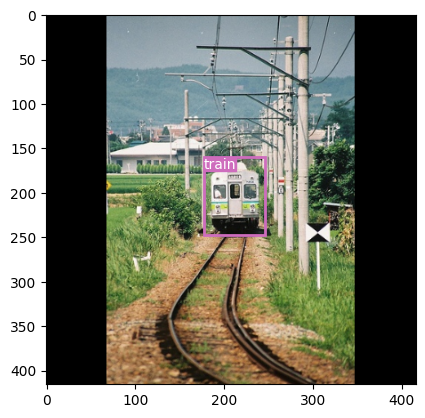

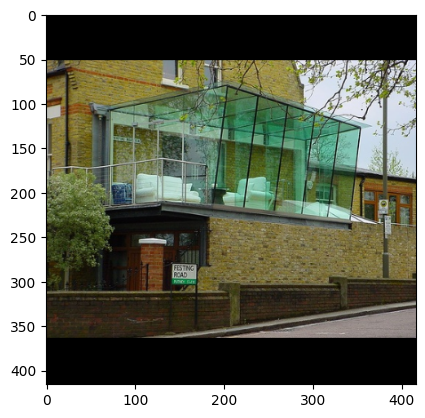

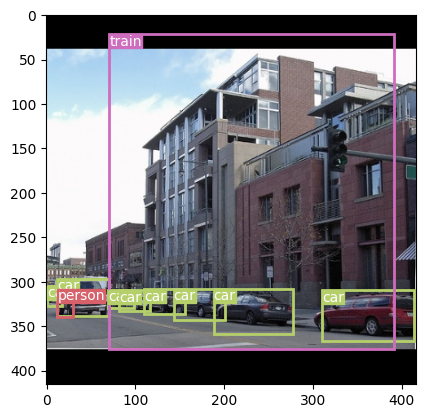

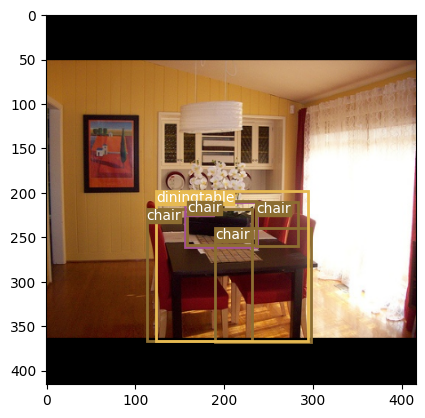

100%|██████████| 310/310 [00:31<00:00,  9.87it/s]


Class accuracy is: 88.935997%
No obj accuracy is: 98.908562%
Obj accuracy is: 72.881683%


100%|██████████| 310/310 [10:44<00:00,  2.08s/it]


MAP: 0.46023011207580566


In [ ]:
from dl_hub.YOLO_V3.PL_main import calc_MAP
test_loader = yolo_dm.test_dataloader()
calc_MAP(yolo_model.to(config.DEVICE), test_loader, config, scaled_anchors)

In [ ]:
yolo_model_trained = yolo_model

**Load trained model**

In [8]:
model_path = "/content/gdrive/MyDrive/trained_models/YOLOv3/75_mosaic_checkpoint_epoch_39_step_74480.ckpt"

In [9]:
from torch.optim.lr_scheduler import OneCycleLR
# Define model parameters
scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to(config.DEVICE)
# Define Model
yolo_model_trained = LitYOLOv3.load_from_checkpoint(model_path)


**Fetch data loaders**

In [10]:

train_data_loader = yolo_dm.train_dataloader()
test_data_loader = yolo_dm.test_dataloader()


**Define the targets for GradCAM**

In [43]:
import torchvision
from dl_hub.YOLO_V3.yolo_v3_utils.utils import non_max_suppression, plot_image
from pytorch_grad_cam import AblationCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image
from PIL import Image
import cv2
import numpy as np

# This will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(config.PASCAL_CLASSES), 3))

class YOLOv3Target:
    pass

def get_box_coords(box, im):
    height, width, _ = im.shape
    upper_left_x = int((box[0] - box[2] / 2)*width)
    upper_left_y = int((box[1] - box[3] / 2)*height)
    lower_right_x = upper_left_x + int(box[2]*width)
    lower_right_y = upper_left_y + int(box[3]*height)
    return [upper_left_x, upper_left_y, lower_right_x, lower_right_y]


def draw_boxes(boxes, labels, classes, confidences, image):
    for i, box in enumerate(boxes):
        color = COLORS[labels[i]]
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color, 2
        )
        cv2.putText(image, f"{classes[i]}({confidences[i]:0.2f})", (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2,
                    lineType=cv2.LINE_AA)
    return image


def get_eigen_cam_image_overlay(boxes,
                                image_float_np,
                                grayscale_cam,
                                renormalize=False,
                                image_weight=0.7):
    """
    Show the CAM image along with the detected bounding boxes.
    If renormalize is set to true,Normalize the CAM to be in the range [0, 1]
    inside every bounding boxes, and zero outside of the bounding boxes.
    """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    box_coords = []
    if renormalize:
        for box in boxes:
            [x1,y1,x2,y2] = get_box_coords(box[2:],image_float_np)
            img = renormalized_cam * 0
            img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())
            images.append(img)
            box_coords.append([x1,y1,x2,y2])
            renormalized_cam = np.max(np.float32(images), axis = 0)
            renormalized_cam = scale_cam_image(renormalized_cam)
            eigen_cam_image = show_cam_on_image(image_float_np,
                                                renormalized_cam,
                                                use_rgb=True,
                                                image_weight=image_weight)
    else:
        eigen_cam_image =  show_cam_on_image(image_float_np,
                                             grayscale_cam,
                                             use_rgb=True,
                                             image_weight=image_weight)
    return eigen_cam_image

def export_image_with_bounding_box(image, boxes,labels, classes, confidences):
    box_coords = []
    for box in boxes:
        [x1,y1,x2,y2] = get_box_coords(box[2:],image)
        box_coords.append([x1,y1,x2,y2])
    pil_img = Image.fromarray(draw_boxes(box_coords,labels,classes,confidences,image))
    return pil_img


In [29]:
import numpy as np
import matplotlib.pyplot as plt


def get_labels(boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.COCO_LABELS if config.DATASET=='COCO' else config.PASCAL_CLASSES
    all_class_names = []
    all_class_labels = []
    all_confidences = []
    for box in boxes:
        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        class_pred = box[0]
        class_name = class_labels[int(class_pred)]
        all_class_names.append(class_name)
        class_label = int(class_pred)
        all_class_labels.append(class_label)
        all_confidences.append(box[1])
    return all_class_names, all_class_labels, all_confidences


def predict(model, loader, anchors, device, thresh=0.6, iou_thresh=0.5):
    model.eval()
    x, y = next(iter(loader))
    num_images = x.shape[0]
    x = x.to(device)
    global_height, global_width = x.shape[-2:]
    boxes_list = []
    classes_list = []
    labels_list = []
    confidences_list = []
    with torch.no_grad():
        out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors[i]
            boxes_scale_i = cells_to_bboxes(
                out[i], anchor, S=S, is_preds=True
            )
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box
    for i in range(num_images):
        nms_boxes = non_max_suppression(
            bboxes[i], iou_threshold=iou_thresh, threshold=thresh, box_format="midpoint",
        )
        classes, labels, confidences = get_labels(nms_boxes)
        boxes_list.append(nms_boxes)
        classes_list.append(classes)
        labels_list.append(labels)
        confidences_list.append(confidences)
    x_np_float_array = np.asarray(x.cpu())
    return x, x_np_float_array, boxes_list, classes_list, labels_list, confidences_list


In [63]:
# Target layer for lowest scale prediction: yolo_model_trained.model.layers[-1].pred[0]
# Target layer for 2nd lowest scale prediction: yolo_model_trained.model.layers[22].pred[0]
# Target layer for highest scale prediction: yolo_model_trained.model.layers[15].pred[0]
target_layers = [yolo_model_trained.model.layers[15].pred[0],
                 yolo_model_trained.model.layers[22].pred[0],
                 yolo_model_trained.model.layers[-1].pred[0]]
targets = [YOLOv3Target()]
cam = EigenCAM(yolo_model_trained,
               target_layers,
               use_cuda=torch.cuda.is_available(),
               reshape_transform=None)
input_tensor, image_float_np, boxes, classes, labels, confidences = predict(
    yolo_model_trained,
    test_data_loader,
    scaled_anchors,
    device = config.DEVICE,
    thresh=0.6,
    iou_thresh=0.3)
grayscale_cam = cam(input_tensor, targets=targets)


In [41]:
confidences

[0.7400769591331482]

In [64]:
renormalize_cam = False
image_weight = 0.7
#img_cv = cv2.cvtColor(np.uint8(image_float_np*255), cv2.COLOR_BGR2RGB)
#image_float_np[cnt].squeeze().transpose((1,2,0))
for cnt in range(input_tensor.shape[0]):
    composite_img = get_eigen_cam_image_overlay(boxes[cnt],
                                      image_float_np[cnt].squeeze().transpose((1,2,0)),
                                      grayscale_cam[cnt].squeeze().T,
                                      renormalize=renormalize_cam,
                                      image_weight=image_weight)
    composite_img_w_bb = export_image_with_bounding_box(composite_img,
                                                        boxes[cnt],
                                                        labels[cnt],
                                                        classes[cnt],
                                                        confidences[cnt])
    composite_img_w_bb.save(f'test3_{cnt}.png')


In [ ]:
import torchinfo

def model_summary(model, input_size):
    torchinfo.summary(model,
                      input_size = input_size,
                      batch_dim=0,
                      col_names=("kernel_size",
                                 "input_size",
                                 "output_size",
                                 "num_params",
                                 "mult_adds"),
                       verbose=1,)

model_summary(yolo_model_trained, (3, 416, 416))

Layer (type:depth-idx)                                  Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
LitYOLOv3                                               --                        [1, 3, 416, 416]          [1, 3, 13, 13, 25]        --                        --
├─YOLOv3: 1-1                                           --                        --                        --                        --                        --
│    └─ModuleList: 2-1                                  --                        --                        --                        --                        --
│    │    └─CNNBlock: 3-1                               --                        [1, 3, 416, 416]          [1, 32, 416, 416]         928                       149,520,448
│    │    └─CNNBlock: 3-2                               --                        [1, 32, 416, 416]         [1, 64, 208, 208]         18,560                    797,442,1